##### Hydrology and Water Resources
## Helper for Assignment 5
### Introduction
This is a Jupyter workbook (https://jupyter.org/). Basically, it’s an online tool where you can run and modify Python code in real time and side by side.
Python is an easy‑to‑learn and very useful language, and it can … (boardinfinity.com/top-10-programming-languages-of-the-future/).
Certainly, mastering Python can help you thrive in your professional life, whether technical or academic.

In this workbook, divided into several steps, you can compute the … for the Hydrology and Water Resources assignment. I hope it’s useful.

Shift–Enter lets you advance through each cell / run the code in that cell. You can edit the cells with the parameters of your assignment.
Each code block is accompanied by a short explanation and, occasionally, comments.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapefile as shp 
from matplotlib.patches import StepPatch

cm = 1/2.54  # conversão de cm para polegadas (útil para controlar o tamanho das figuras)

### Enter the base data
Below you can replace the default data with those of your watershed.

Comments are marked with "\#"

In [2]:
# Geomorphology
area = 68.051078 # [km2]
comprimento = 14.21018787 # Length of the main channel [km]
altura_media = 500 # Average height [m]
diferenca_cotas = 521.86 # Diffence in elevations within the main watercourse [m]
declive_medio = 0.036724 # Average slope [-] ou [m/m]
declive_10_85 = 29.723 # 10:85 slope [m/km]

# Precipitation
    # Number of blocks
numero_blocos = 10

    # Coef. of the D-D-F P=a*t^n for P in [mm] and t in [hr].
n = 0.3282
a_hr = 29.999
    # Calculation for t in [min]
a = a_hr/60**n

    # Losses (e.g., infiltration, detention, interception, evaporation, etc.)
perdas = 0.25

# Calculation time step "D" as a fraction of the time of concentration.
d = 1/10 # 

# Caracterization of the HUD with pairs of coordinates (x, y) in units of "D".
hud = [(0,0),
      (4,1),
      (11,0),
      ]

### Calculate the time of concentration
According to the formulas of:
-  Giandotti: $t_c=\frac{4\sqrt{A}+1.5L}{0.8\sqrt{hm}}$
-  Temez: $t_c=0.3\Big(\frac{L}{dm^{0.25}}\Big)^{0.75}$
-  NERC: $t_c=2.8\Big(\frac{L}{\sqrt{d_{10:85}}}\Big)^{0.47}$
-  Kirpich: $t_c=0.95\frac{L^{1.155}}{H^{0.385}}$

The units of each variable are indicated above (enter the base data).
All formulas return the estimated time of concentration in hours.

The value to use corresponds to the average of the previous estimates.


In [3]:
# Calculation of tc
tcs = {}
tcs['Giandotti'] = (4*area**0.5+1.5*comprimento)/(0.8*altura_media**0.5)
tcs['Temez'] = 0.3*(comprimento/(declive_medio**0.25))**0.76
tcs['NERC'] = 2.8*(comprimento/(declive_10_85)**0.5)**0.47
tcs['Kirpich'] = 0.95*(comprimento**1.155/diferenca_cotas**0.385)

tcs = pd.DataFrame(data=tcs, index=['tc [hr]']).transpose()
tc = tcs.mean().values[0]

print('The estimated value is %0.2f hours.' % tc)
tcs

The estimated value is 3.37 hours.


,tc [hr]
Giandotti,3.036162
Temez,4.224318
NERC,4.392413
Kirpich,1.831125


### Prepare the unit hydrograph
The UH coordinates entered above will be used to … so that the unit hydrograph corresponds to 1 mm of rainfall with duration “D”.


For a net precipitation of 1 mm, the volume is 68.05 dam3.
With a umax of 1.00 m3/s/mm, the direct runoff volume is 6.67 dam3.
O HUD de base é:


,time [hr],u [m3/s],rank
D,,,
0,0.000000,0.000000,11
1,0.337100,2.548886,9
2,0.674201,5.097773,6
3,1.011301,7.646659,3
4,1.348402,10.195546,1
5,1.685502,8.739039,2
6,2.022603,7.282533,4
7,2.359703,5.826026,5
8,2.696804,4.369520,7


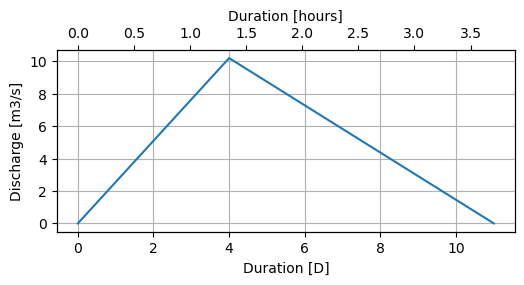

In [4]:
# Unit hydrograph
d_hr = tc*d

x_hud = np.arange(hud[0][0], hud[-1][0]+1)*d_hr
u_hud = np.interp(x_hud, [x[0]*d_hr for x in hud], [y[1] for y in hud])
#u_hud /= max(u_hud)

vol_pe_1mm = area*1000000*0.001 # em m3
vol_hud = sum(u_hud[1:]+u_hud[0:-1])/2*d_hr*3600 # in m3.
hud_1mm = pd.DataFrame({'time [hr]': x_hud,
             'u [m3/s]': u_hud*vol_pe_1mm/vol_hud,
             })
hud_1mm.index.name = 'D'
hud_1mm.loc[:, 'rank'] = hud_1mm.loc[:, 'u [m3/s]'].rank(ascending=False).astype(int)

fig = plt.figure(figsize=(15*cm, 6*cm))
gs = fig.add_gridspec(nrows=1, ncols=2)

    # Hyetograph
ax0 = fig.add_subplot(gs[:, :])
ax0.plot(hud_1mm.index, hud_1mm.loc[:, 'u [m3/s]'])
ax0.set_xlabel('Duration [D]')
ax0.set_ylabel('Discharge [m3/s]')
plt.grid()
ax1 = ax0.twiny()
ax1.set_xlim(ax0.get_xlim()[0]*d_hr, ax0.get_xlim()[1]*d_hr)
ax1.set_xlabel('Duration [hours]')

print('For a net precipitation of 1 mm, the volume is %0.2f dam3.' % (vol_pe_1mm/1000))
print('With a umax of %0.2f m3/s/mm, the direct runoff volume is %0.2f dam3.' % (max(u_hud), vol_hud/1000))
print('O HUD de base é:')
hud_1mm



### Plot the IDF curve
Having calculated $t_c$, it is possible to estimate the design precipitation for a given return period (in our case 100 years).
To do so, it is necessary to use the intensity–duration–frequency (IDF) curve.


For a return period of 100 years, tc is 3.37 hours and the design precipitation 44.70 mm.


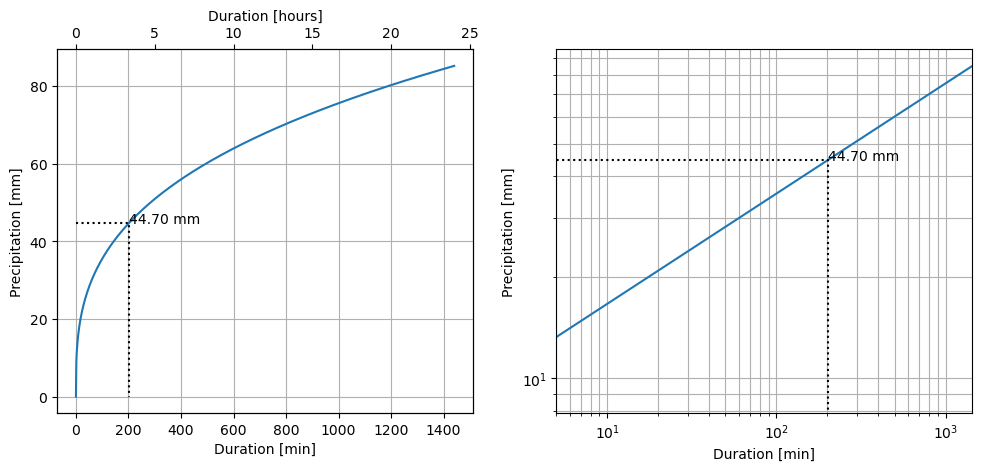

In [ ]:
p_projecto = a*(tc*60)**n # *60 to convert hours to minutes.
print('For a return period of 100 years, tc is %0.2f hours and the design precipitation %0.2f mm.' % (tc, p_projecto))

# Graphs
    # Original
x = np.linspace(0, 24*60, 1000)
p = a*x**n

fig = plt.figure(figsize=(30*cm, 12*cm))
gs = fig.add_gridspec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[:, 1])

_ = ax0.plot(x, p)
ax0.set_xlabel('Duration [min]')
ax0.set_ylabel('Precipitation [mm]')

        # Annotations and style
ax0.plot([0, tc*60, tc*60],[p_projecto, p_projecto, 0], ':k')
ax0.annotate('%0.2f mm' % p_projecto, (tc*60, p_projecto))
ax0.grid()
        
        # Secondary horizontal axis
ax2 = ax0.twiny()
ax2.set_xlim(ax0.get_xlim()[0]/60, ax0.get_xlim()[1]/60)
ax2.set_xlabel('Duration [hr]')

    # Log. scale
_ = ax1.loglog(x, p)
ax1.set_xlabel('Duration [min]')
ax1.set_ylabel('Precipitation [mm]')

        # Annotations and style
ax1.plot([0, tc*60, tc*60],[p_projecto, p_projecto, 0], ':k')
ax1.annotate('%0.2f mm' % p_projecto, (tc*60, p_projecto))
ax1.grid(True, which="both")
_ = ax1.set_xlim(5, 24*60)

### Prepare hyetographs
The uniform and alternating‑block hyetographs are prepared with the following code.


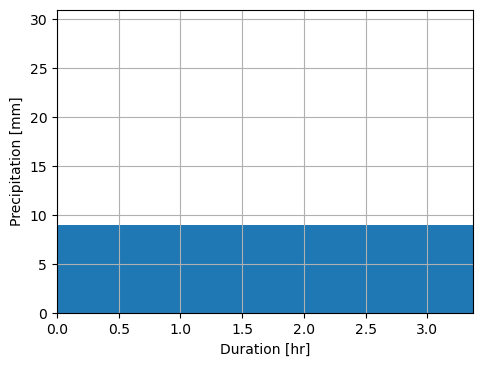

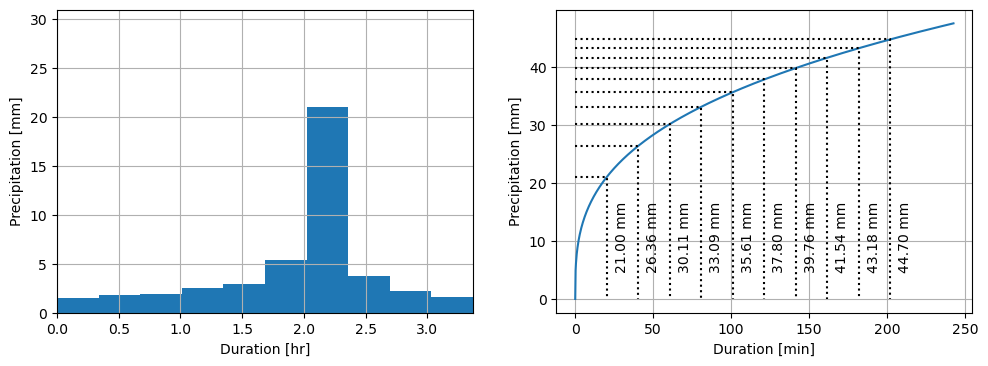

In [6]:
# Design hyetographs

# Uniform
intensidade = p_projecto/tc/60 # i [mm/min]
duracao = tc/numero_blocos*60 # min

fig = plt.figure(figsize=(30*cm, 10*cm))
gs = fig.add_gridspec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[:, 0])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=[intensidade*tc/5*60]*numero_blocos)
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duration [hr]')
ax0.set_ylabel('Precipitation [mm]')
ax0.grid()

# Alternate
x = np.linspace(0, 6*tc/5*60, 1000)
p = a*(x)**n

    # Values per block
x_alternado = np.linspace(0, tc, numero_blocos+1)
p_alternado = a*(x_alternado*60)**n

p_diferencas = np.diff(p_alternado)
i_h_alternado = hud_1mm.loc[:, 'rank'].iloc[1:-1][::-1]-1
p_h_alternado = p_diferencas[i_h_alternado]


fig = plt.figure(figsize=(30*cm, 10*cm))
    # Hyetograph
ax0 = fig.add_subplot(gs[:, 0])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=p_h_alternado)
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duration [hr]')
ax0.set_ylabel('Precipitation [mm]')
plt.grid()

    # Annotated D-D-F
gs = fig.add_gridspec(nrows=1, ncols=2)
ax1 = fig.add_subplot(gs[:, 1])
_ = ax1.plot(x, p)
ax1.set_xlabel('Duration [min]')
ax1.set_ylabel('Precipitation [mm]')
for i0 in range(0, numero_blocos):
    ax1.plot([0, x_alternado[i0+1]*60, x_alternado[i0+1]*60],[p_alternado[i0+1], p_alternado[i0+1], 0], ':k')
    ax1.annotate('%0.2f mm' % p_alternado[i0+1], ((i0+1)*tc/numero_blocos*60+5, 5), rotation=90, annotation_clip=False, textcoords='data')
plt.grid()



### Compute net precipitation
To compute the net precipitation we remove the losses (in this case assumed constant). The value of the losses has already been entered above.


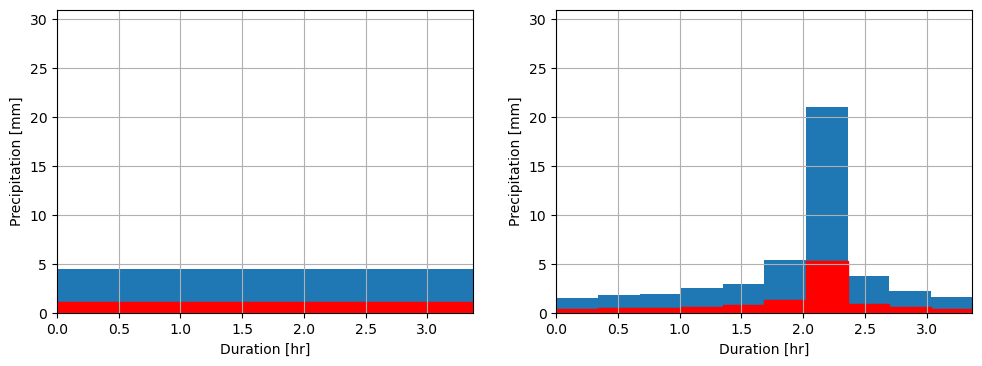

In [7]:
# Net precipitation

blocos = np.arange(1, numero_blocos+1)
p_h_uniforme = np.ones(numero_blocos)*intensidade*tc/numero_blocos*60
p_h_alternado = p_h_alternado
hietogramas = pd.DataFrame({'Uniform blocks [mm]': p_h_uniforme, 'Alternate blocks [mm]': p_h_alternado})
hietogramas.index = pd.MultiIndex.from_arrays([blocos, np.int32(blocos/d/numero_blocos), blocos*tc/numero_blocos], names=('Blocks', 'D', 'Hours'))

p_perdas = hietogramas*perdas
p_efectiva = hietogramas-p_perdas

fig = plt.figure(figsize=(30*cm, 10*cm))
    # Uniforme
ax0 = fig.add_subplot(gs[:, 0])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=hietogramas.loc[:, 'Uniform blocks [mm]'])
ax0.add_patch(patch)
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=p_perdas.loc[:, 'Uniform blocks [mm]'], color='red')
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duration [hr]')
ax0.set_ylabel('Precipitation [mm]')
plt.grid()

    # Alternate
ax0 = fig.add_subplot(gs[:, 1])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=hietogramas.loc[:, 'Alternate blocks [mm]'])
ax0.add_patch(patch)
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=p_perdas.loc[:, 'Alternate blocks [mm]'], color='red')
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duration [hr]')
ax0.set_ylabel('Precipitation [mm]')
plt.grid()


In [8]:
print('Total precipitation hyetographs')
hietogramas

Total precipitation hyetographs


,,,Uniform blocks [mm],Alternate blocks [mm]
Blocks,D,Hours,,
1,1,0.337100,4.470102,1.519311
2,2,0.674201,4.470102,1.781360
3,3,1.011301,4.470102,1.961656
4,4,1.348402,4.470102,2.514412
5,5,1.685502,4.470102,2.981424
6,6,2.022603,4.470102,5.363108
7,7,2.359703,4.470102,20.995073
8,8,2.696804,4.470102,3.751669
9,9,3.033904,4.470102,2.195606


In [9]:
print('')
print('Net precipitation hyetographs')
p_efectiva


Net precipitation hyetographs


,,,Uniform blocks [mm],Alternate blocks [mm]
Blocks,D,Hours,,
1,1,0.337100,3.352576,1.139483
2,2,0.674201,3.352576,1.336020
3,3,1.011301,3.352576,1.471242
4,4,1.348402,3.352576,1.885809
5,5,1.685502,3.352576,2.236068
6,6,2.022603,3.352576,4.022331
7,7,2.359703,3.352576,15.746305
8,8,2.696804,3.352576,2.813752
9,9,3.033904,3.352576,1.646704


### Run the convolution (uniform hyetograph)
We now have all the information needed to compute the hydrograph … for the 100‑year return period. First, the uniform hyetograph …


,Block 1,Block 2,Block 3,Block 4,Block 5,Block 6,Block 7,Block 8,Block 9,Block 10,Discharge [m3/s]
D,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,8.545336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.545336
2,17.090672,8.545336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.636008
3,25.636008,17.090672,8.545336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.272015
4,34.181344,25.636008,17.090672,8.545336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,85.453359
5,29.298295,34.181344,25.636008,17.090672,8.545336,0.000000,0.000000,0.000000,0.000000,0.000000,114.751654
6,24.415245,29.298295,34.181344,25.636008,17.090672,8.545336,0.000000,0.000000,0.000000,0.000000,139.166899
7,19.532196,24.415245,29.298295,34.181344,25.636008,17.090672,8.545336,0.000000,0.000000,0.000000,158.699095
8,14.649147,19.532196,24.415245,29.298295,34.181344,25.636008,17.090672,8.545336,0.000000,0.000000,173.348243


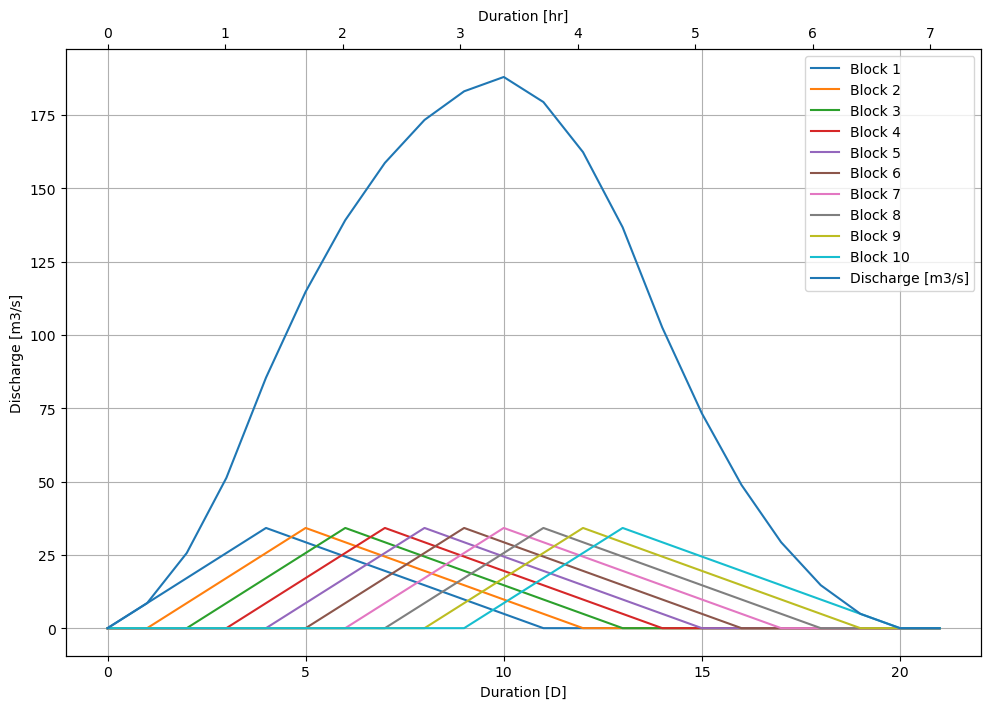

In [10]:
# Convolution (uniform)

# Dividir blocks
p_tmp = p_efectiva.loc[:, ['Uniform blocks [mm]']].copy()
p_tmp.index = p_tmp.index.get_level_values(1)
p_tmp = p_tmp.reindex(np.int32(np.arange(1, 1/d+1)))
p_tmp = p_tmp.bfill()

# Calculate
hud_1mm = hud_1mm.reindex(np.int32(np.arange(0, hud[-1][0] + 1/d + 1)))
hidrogramas_unif = []
for d0 in p_tmp.index:
    hidrogramas_unif.append((p_tmp.iloc[d0-1, 0]*hud_1mm.loc[:, 'u [m3/s]']).shift(d0-1))
hidrogramas_unif = pd.concat(hidrogramas_unif, axis=1)
hidrogramas_unif = hidrogramas_unif.fillna(0)
hidrogramas_unif.columns = ['Block %d' % i for i in p_tmp.index]

hidrogramas_unif.loc[:, 'Discharge [m3/s]'] = hidrogramas_unif.sum(axis=1)

# Draw figure
fig = plt.figure(figsize=(30*cm, 20*cm))

ax0 = fig.add_subplot(gs[:, :])
hidrogramas_unif.plot(ax=ax0)
ax0.set_xlabel('Duration [D]')
ax0.set_ylabel('Discharge [m3/s]')
plt.grid()
ax1 = ax0.twiny()
ax1.set_xlim(ax0.get_xlim()[0]*d_hr, ax0.get_xlim()[1]*d_hr)
_ = ax1.set_xlabel('Duration [hr]')

hidrogramas_unif

### Run the convolution (alternating‑block hyetograph)
The same for the alternating hyetograph …


,Block 1,Block 2,Block 3,Block 4,Block 5,Block 6,Block 7,Block 8,Block 9,Block 10,Discharge [m3/s]
D,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.904413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.904413
2,5.808827,3.405364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.214191
3,8.713240,6.810727,3.750030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.273997
4,11.617654,10.216091,7.500059,4.806712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.140516
5,9.957989,13.621455,11.250089,9.613425,5.699483,0.000000,0.000000,0.000000,0.000000,0.000000,50.142440
6,8.298324,11.675533,15.000118,14.420137,11.398966,10.252465,0.000000,0.000000,0.000000,0.000000,71.045542
7,6.638659,9.729611,12.857244,19.226849,17.098449,20.504929,40.135543,0.000000,0.000000,0.000000,126.191284
8,4.978994,7.783688,10.714370,16.480156,22.797932,30.757394,80.271085,7.171933,0.000000,0.000000,180.955554


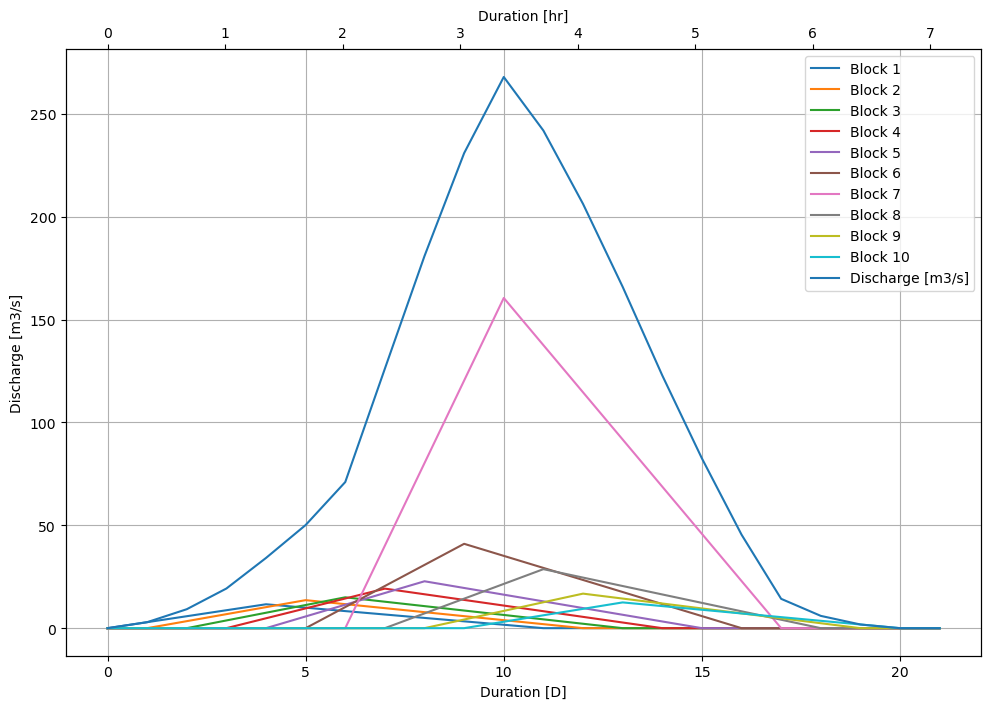

In [11]:
# Convolution (alternating)

# Divide blocks
p_tmp = p_efectiva.loc[:, ['Alternate blocks [mm]']].copy()
p_tmp.index = p_tmp.index.get_level_values(1)
p_tmp = p_tmp.reindex(np.int32(np.arange(1, 1/d+1)))
p_tmp = p_tmp.bfill()

# Calculate
hud_1mm = hud_1mm.reindex(np.int32(np.arange(0, hud[-1][0] + 1/d + 1)))
hidrogramas_alt = []
for d0 in p_tmp.index:
    hidrogramas_alt.append((p_tmp.iloc[d0-1, 0]*hud_1mm.loc[:, 'u [m3/s]']).shift(d0-1))
hidrogramas_alt = pd.concat(hidrogramas_alt, axis=1)
hidrogramas_alt = hidrogramas_alt.fillna(0)
hidrogramas_alt.columns = ['Block %d' % i for i in p_tmp.index]

hidrogramas_alt.loc[:, 'Discharge [m3/s]'] = hidrogramas_alt.sum(axis=1)

# Draw figure
fig = plt.figure(figsize=(30*cm, 20*cm))
ax0 = fig.add_subplot(gs[:, :])
hidrogramas_alt.plot(ax=ax0)
ax0.set_xlabel('Duration [D]')
ax0.set_ylabel('Discharge [m3/s]')
plt.grid()
ax1 = ax0.twiny()
ax1.set_xlim(ax0.get_xlim()[0]*d_hr, ax0.get_xlim()[1]*d_hr)
_ = ax1.set_xlabel('Duration [hr]')

hidrogramas_alt

### Calculation of volumes and peak discharge using the Rational Method


In [12]:
volume_uniforme_hm3 = (hidrogramas_unif.iloc[1:, [-1]] + hidrogramas_unif.iloc[:-1, [-1]]).sum()*d*tc*3600/1000000/2
volume_alternado_hm3 = (hidrogramas_alt.iloc[1:, [-1]] + hidrogramas_alt.iloc[:-1, [-1]]).sum()*d*tc*3600/1000000/2

print(f'The direct runoff volumes are: {volume_uniforme_hm3.values[0]:.2f} hm3 (uniform hyetograph) and {volume_alternado_hm3.values[0]:.2f} hm3 (alternate hyetograph).')

C_ = (1-perdas)
i_ = p_projecto/tc/3600/1000 # m/s
A_ = area * 1000000 # m2

Qp_uniforme = C_*i_*A_

f = 2-np.sqrt(n)
Qp_alternado = Qp_uniforme * f

print('The peak discharges are:')
pd.DataFrame({'Qp_unif. [m3/s]': hidrogramas_unif.iloc[:, -1].max(),
              'Qp_rational [m3/s]': Qp_uniforme,
              'intensity [m/s]': i_,
              'area [m]': A_,
              'Qp_altern. [m3/s]': hidrogramas_alt.iloc[:, -1].max(),
              'Qp_rational_maj. [m3/s]': Qp_alternado,
              'maj. factor [-]': f}, index=['Values'],
              )

The direct runoff volumes are: 2.28 hm3 (uniform hyetograph) and 2.28 hm3 (alternate hyetograph).
The peak discharges are:


,Qp_unif. [m3/s],Qp_rational [m3/s],intensity [m/s],area [m],Qp_altern. [m3/s],Qp_rational_maj. [m3/s],maj. factor [-]
Values,187.99739,187.99739,0.000004,68051078.0,267.985095,268.29344,1.427113


### Finally, compare the two …


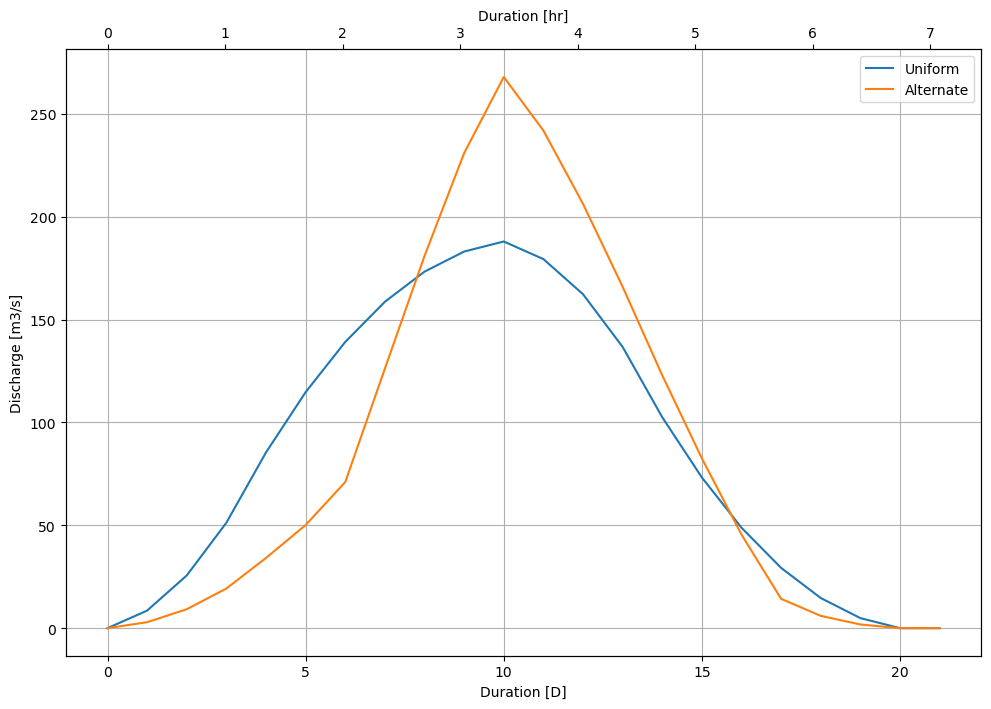

In [13]:
hidrogramas = pd.concat((hidrogramas_unif.loc[:, 'Discharge [m3/s]'], hidrogramas_alt.loc[:, 'Discharge [m3/s]']), axis=1)
hidrogramas.columns = ['Uniform', 'Alternate']

fig = plt.figure(figsize=(30*cm, 20*cm))
ax0 = fig.add_subplot(gs[:, :])
hidrogramas.plot(ax=ax0)
ax0.set_xlabel('Duration [D]')
ax0.set_ylabel('Discharge [m3/s]')
plt.grid()
ax1 = ax0.twiny()
ax1.set_xlim(ax0.get_xlim()[0]*d_hr, ax0.get_xlim()[1]*d_hr)
_ = ax1.set_xlabel('Duration [hr]')